In [1]:
import torch 
import numpy as np 
import random 

def same_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
same_seeds(2526)

## 讀檔

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_and_process_data(filepath, test_size = 0.2, random_state = 42):
    df = pd.read_csv(filepath)
    reviews = df['review'].values
    sentiments_raw = df['sentiment'].values
    sentiments = (sentiments_raw == 'positive').astype('float32')
    print('Original labels:\n', sentiments_raw, end = '\n\n')
    print('Converted labels:\n', sentiments)

    train_texts, valid_texts, train_labels, valid_labels = train_test_split(
        reviews, sentiments, test_size = test_size, random_state = random_state
    )

    return train_texts, valid_texts, train_labels, valid_labels, sentiments

train_texts, valid_texts, train_labels, valid_labels, sentiments = load_and_process_data('sentimentData/IMDB Dataset.csv')


Original labels:
 ['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']

Converted labels:
 [1. 1. 1. ... 0. 0. 0.]


## 創建資料集

In [3]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

class IMDB(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer
          
    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
    def collate_fn(self, batch):
        x, y = zip(*batch)
        encodings = self.tokenizer(x, padding=True, truncation=True, max_length=256, return_tensors='pt')
        encodings['labels'] = torch.tensor(y)
        return encodings

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

trainset = IMDB(train_texts, train_labels, tokenizer)
validset = IMDB(valid_texts, valid_labels, tokenizer)

train_loader = DataLoader(
    trainset,
    batch_size = 64,
    shuffle = True,
    num_workers = 0,
    pin_memory = True,
    collate_fn = trainset.collate_fn
)

valid_loader = DataLoader(
    validset,
    batch_size = 64,
    shuffle = False,
    num_workers = 0,
    pin_memory = True,
    collate_fn = validset.collate_fn
)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

    class GRU(nn.Module):
        def __init__(self, embedding_dim, hidden_size, input_dim, pad_idx, num_layers, bidirectional):
            super(GRU, self).__init__()
            self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
            self.gru = nn.GRU(
                input_size = embedding_dim,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first = True,
                bidirectional = bidirectional
            )
            self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size)
            self.classifier = nn.Linear(hidden_size, 1)
            self.criterion = nn.BCEWithLogitsLoss()
            self.pad_idx = pad_idx
            self.sigmoid = nn.Sigmoid()

        def forward(self, **kwargs):
            input_ids = kwargs["input_ids"]
            attention_mask = kwargs["attention_mask"]
            labels = kwargs["labels"]
            lengths = attention_mask.sum(dim = 1)

            embedded = self.embedding(input_ids)
            packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first = True, enforce_sorted = False)
            packed_output, hidden = self.gru(packed_embedded)
            output, _ = pad_packed_sequence(packed_output, batch_first = True)

            if self.gru.bidirectional:
                hidden = torch.cat((hidden[-2], hidden[-1]), dim = 1)
            else:
                hidden = hidden[-1]

            output = self.fc(hidden)
            logits = self.classifier(output).squeeze(1)
            loss = self.criterion(logits, labels.float())

            return loss, logits

        def predict(self, **kwargs):
            self.eval()
            with torch.no_grad():
                input_ids = kwargs["input_ids"]
                attention_mask = kwargs["attention_mask"]
                lengths = attention_mask.sum(dim = 1)

                embedded = self.embedding(input_ids)
                packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first = True, enforce_sorted = False)
                packed_output, hidden = self.gru(packed_embedded)
                output, _ = pad_packed_sequence(packed_output, batch_first = True)

                if self.gru.bidirectional:
                    hidden = torch.cat((hidden[-2], hidden[-1]), dim = 1)
                else:
                    hidden = hidden[-1]

                output = self.fc(hidden)
                logits = self.classifier(output).squeeze(1)

                probs = self.sigmoid(logits)
                preds = (probs >= 0.5).long()

                return preds


    model = GRU(
        embedding_dim = 128,
        hidden_size = 256,
        input_dim = tokenizer.vocab_size,
        pad_idx = tokenizer.pad_token_id,
        num_layers = 1,
        bidirectional = True
    )

Using device: cuda


Valid Epoch 0: 100%|██████████| 157/157 [00:44<00:00,  3.57it/s, loss=0.403]


Saving Model With Loss 0.35010
Train Loss: 0.56697| Valid Loss: 0.35010| Best Loss: 0.35010



Valid Epoch 1: 100%|██████████| 157/157 [00:40<00:00,  3.92it/s, loss=0.341]


Saving Model With Loss 0.27443
Train Loss: 0.29192| Valid Loss: 0.27443| Best Loss: 0.27443



Valid Epoch 2: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s, loss=0.337]


Train Loss: 0.19585| Valid Loss: 0.28556| Best Loss: 0.27443



Valid Epoch 3: 100%|██████████| 157/157 [00:41<00:00,  3.78it/s, loss=0.460]


Train Loss: 0.11428| Valid Loss: 0.32471| Best Loss: 0.27443



Valid Epoch 4: 100%|██████████| 157/157 [00:41<00:00,  3.74it/s, loss=0.588]


Train Loss: 0.04751| Valid Loss: 0.47351| Best Loss: 0.27443



Valid Epoch 5: 100%|██████████| 157/157 [00:41<00:00,  3.74it/s, loss=0.282]


Train Loss: 0.01897| Valid Loss: 0.65168| Best Loss: 0.27443



Valid Epoch 6: 100%|██████████| 157/157 [00:41<00:00,  3.74it/s, loss=0.843]


Train Loss: 0.01648| Valid Loss: 0.71814| Best Loss: 0.27443

------------------------------------
|Model can't improve, stop training|
------------------------------------


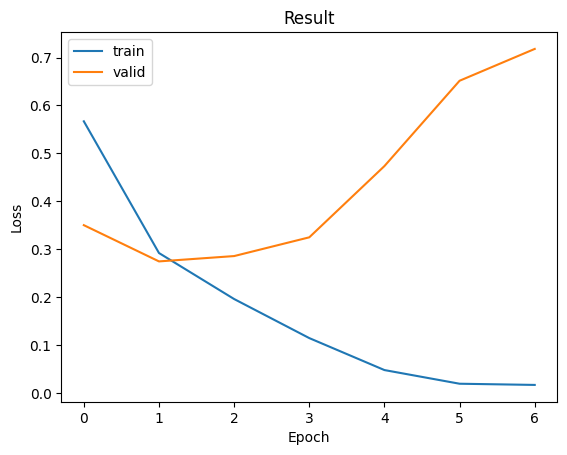

Best model loaded from ./checkpoints\best_model.ckpt


In [5]:
from Trainer import Trainer
import torch.optim as optim 
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
trainer = Trainer(
    epochs=100,
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    optimizer=optimizer,
    early_stopping=5,
    load_best_model=True,
    grad_clip=1.0,
)

trainer.train(show_loss=True)

Evaluating: 100%|██████████| 157/157 [00:41<00:00,  3.76it/s]


              precision    recall  f1-score   support

    negative     0.8659    0.9032    0.8842      4961
    positive     0.9005    0.8623    0.8810      5039

    accuracy                         0.8826     10000
   macro avg     0.8832    0.8828    0.8826     10000
weighted avg     0.8833    0.8826    0.8826     10000



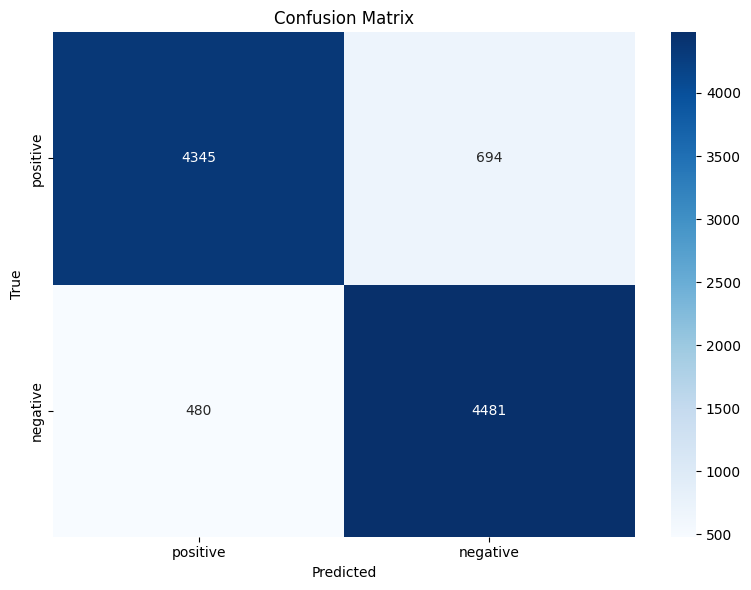

In [6]:
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, label_decoding, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    all_preds, all_labels = [], []
    for batch in tqdm(data_loader, desc='Evaluating'):
        batch = {k: v.to(device) for k, v in batch.items()}
        preds = model.predict(**batch)
        all_preds.extend(preds.tolist())
        all_labels.extend(batch['labels'].tolist())

    # 解碼標籤
    decoded_labels = [label_decoding[l] for l in all_labels]
    decoded_preds = [label_decoding[p] for p in all_preds]

    # 顯示分類報告
    print(classification_report(decoded_labels, decoded_preds, digits=4, zero_division=0))

    # 繪製混淆矩陣
    cm = confusion_matrix(decoded_labels, decoded_preds, labels=list(label_decoding.values()))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_decoding.values(),
                yticklabels=label_decoding.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

label_decoding = {1: 'positive', 0: 'negative'}
evaluate_model(model, valid_loader, label_decoding)


In [7]:
def infer_text_labels(texts):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokens = tokenizer(texts, padding = 'max_length', truncation = True, max_length = 256, return_tensors = 'pt')
    tokens = {k: v.to(device) for k, v in tokens.items()}

    model.to(device)
    model.eval()
    with torch.no_grad():
        preds = model.predict(**tokens)

    labels = [label_decoding[int(p)] for p in preds]

    for text, label in zip(texts, labels):
        print(f"Text: {text}\nLabel: {label}\n")

texts = [
    "This movie was absolutely fantastic and I loved every part of it!",
    "The film was boring and I wouldn't recommend it to anyone."
]

infer_text_labels(texts)

Text: This movie was absolutely fantastic and I loved every part of it!
Label: positive

Text: The film was boring and I wouldn't recommend it to anyone.
Label: negative

